In [11]:
### Preamble ###
## Preamble ###
## Hack code to calculate out snow depth gradients over non ice surfaces
## Code for CBT technical report (snow chapter for CBT Report)
## Requires use of co-registered DEMs and an ice mask
## Brian Menounos 6 April, 2019

## modified for Lajoie snow depths - 24 March, 2020

from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


## enable zooming of plots in this notebook
#import mpld3
#mpld3.enable_notebook()
#from mpld3 import plugins

## enable latex symbols in graphs
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]


path = '/Users/menounos/Downloads/Seymour/'


## this will be done for many sites to make a function call to extract
## data of interest 
## uses panda  
#def make_snow_gradients(path, path_out, be_dem, snow_dem, msk, n_min, map_fname):
def make_snow_gradients(path, be_dem, snow_dem, n_min, map_fname):

    # open GeoTIFF as array
    be_dem   = gdal.Open(path + be_dem).ReadAsArray()
    snow_dem = gdal.Open(path + snow_dem).ReadAsArray()
    #msk      = gdal.Open(path + msk).ReadAsArray() * 1.0
    
    basin    = gdal.Open(path + 'watershed.tif').ReadAsArray() * 1.0
    
    be_dem[be_dem <= 0.0] = np.nan
    snow_dem[snow_dem <= 0.0] = np.nan
    
    #be_dem[basin < 1.0] = np.nan
    
    
    #msk[msk == 0.0] = 2.0
    #msk[msk == 1.0] = np.nan

    print(np.shape(be_dem))
    print(np.shape(snow_dem))
    
    

    #dh = (msk - 1.0) *(snow_dem - be_dem)
    dh = basin * (snow_dem - be_dem)
    
    print(dh.mean())
    
    
    
    #dh = snow_dem - be_dem

    dh[np.abs(dh) > 8.0] = np.nan
    
    dh[dh <= 0.0] = np.nan
     
    ## READ ME - figure out source of offset!!!
    
    dh = dh - 0.21
    
    plt.figure()
    ax = plt.gca()
    im = ax.imshow(dh, cmap='Blues', vmax=8.0)
    
    ax.text(50, 4200, map_fname)
    
    ax.set_xlabel('Easting [m]') 
    ax.set_ylabel('Northing [m]')
    

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax, label ='Snow depth [m]')  #, rotation=270)
  
    plt.tight_layout()
    
    plt.savefig(path + map_fname + '.pdf', dpi=600)
    

    print('Average elevation change:', np.nanmean(dh), 'm')


    # convert 2-d elevation and SWE arrays to 1-D vectors using ravel function
    Zvec = np.ravel(be_dem)
    Depthvec = np.ravel(dh)

    bins = range(100,1800,100)

    # create pandas dataframe for elevation and SWE
    df = pd.DataFrame({"Z":Zvec,"Depth":Depthvec})

    # classify the elevation data into 100 metre bins and add to the data frame 
    df['Zbins'] = pd.cut(df['Z'], bins, labels= np.arange(150, 1750, 100))
    
    df = df.dropna()

    ## get some statistics from the data
    ## this will be series which can be a pain to work with 
    ## so convert to dataframes
    median = df.groupby(by='Zbins')['Depth'].median()
    iqr    = df.groupby(by='Zbins')['Depth'].quantile(0.75) - df.groupby(by='Zbins')['Depth'].quantile(0.25)
    count  = df.groupby(by='Zbins')['Depth'].count()

    ## remove any values that are less than 100 values
    ## these are series not pandas dataframes
    
    ## convert series to pandas data frames instead of series
    
    median = median.to_frame() 
    iqr    = iqr.to_frame()
    count  = count.to_frame()
    
    ## Make combine data frame
    
    median['iqr']   = iqr
    median['count'] = count
    
    ## remove any rows where count is below set threshold
    median[median['count'] < n_min] = np.nan
    
    median = median.dropna()
    
    ## reset index to make Zbins a column rather than an index
    median          = median.reset_index()
    median['Zbins'] = median['Zbins'].tolist()
    
    ## returns data frame 
    
    return median 


(4501, 2879)
(4501, 2879)
nan
('Average elevation change:', 1.9920011581424026, 'm')
(4501, 2879)
(4501, 2879)
nan
('Average elevation change:', 2.133472890767609, 'm')


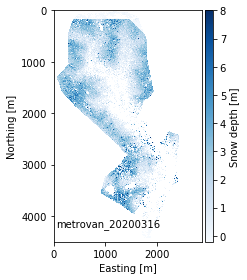

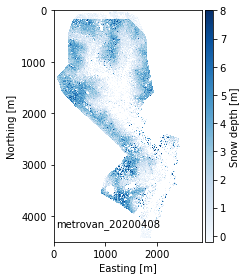

In [12]:
## Call function to make dataframes for plotting

## this sets the minimum count of a given elevation bin

n_min = 10. 

metrovan_20200316 = make_snow_gradients(path, 'dem_5m_seymour_ellipsoidal.tif', 
                    '20200316_metrovan_utm10_slave2.tif', 
                     n_min, 'metrovan_20200316')


metrovan_20200408 = make_snow_gradients(path, 'dem_5m_seymour_ellipsoidal.tif', 
                    '20200408_metrovan_utm10_slave2.tif', 
                     n_min, 'metrovan_20200408')


In [13]:
print(metrovan_20200408)


    Zbins     Depth       iqr     count
0     150  0.006843  0.262249   47172.0
1     250  0.180396  0.961044   98008.0
2     350  0.215140  1.039291   98479.0
3     450  0.224052  0.923706   99651.0
4     550  0.277976  0.738037  128848.0
5     650  0.346396  0.728333  197453.0
6     750  0.618552  0.882446  298485.0
7     850  1.075095  1.076721  385479.0
8     950  1.647178  1.255188  426529.0
9    1050  2.373069  1.304932  562127.0
10   1150  3.004722  1.422852  572743.0
11   1250  3.411094  1.423828  483980.0
12   1350  3.656699  1.588623  320107.0
13   1450  3.607993  2.399292  141615.0
14   1550  3.396262  3.481537   39420.0
15   1650  3.433799  3.264832   10203.0


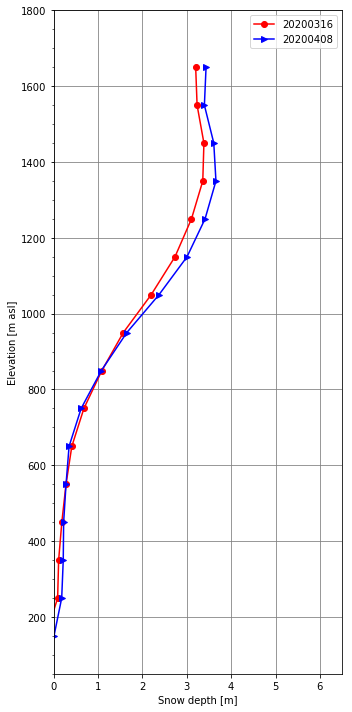

In [14]:

## Code below is a hack. It should be written as a set of functions
## when one has more time (interate over objects and names)

## write dataframes to output
metrovan_20200316.to_csv(path + 'metrovan_20200316.csv')
metrovan_20200408.to_csv(path + 'metrovan_20200408.csv')


## make a few plots
## since function 'make_snow_gradients' returns pandas series with indexes 
## we have to extract values noted in calls to objects in plot values
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

plt.rcParams['figure.figsize'] = 5, 10

fig, ax = plt.subplots()


ax.plot(metrovan_20200316['Depth'], metrovan_20200316['Zbins'],'-ro', label='20200316')

ax.plot(metrovan_20200408['Depth'], metrovan_20200408['Zbins'],'-b>', label='20200408')



ax.set_ylabel('Elevation [m asl]')
ax.set_xlabel('Snow depth [m]')

## These limits are scaled to fit all data 
## to keep scaling consistent. These can be cahnged
ax.set_xlim([0, 6.5])
ax.set_ylim([50, 1800])

# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.yaxis.set_major_locator(MultipleLocator(200))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(50))
plt.grid(color='grey')

plt.tight_layout()
plt.legend()
plt.savefig(path + 'metrovan_snow_gradients.pdf', resolution=600)
plt.show()

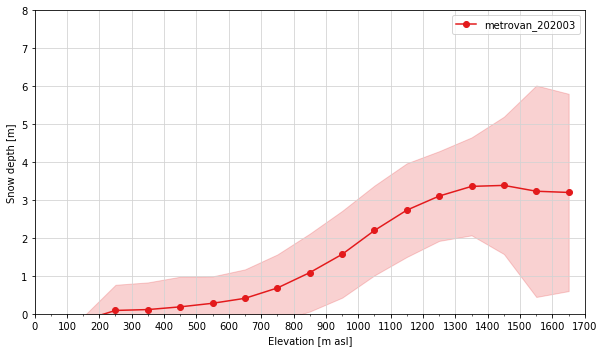

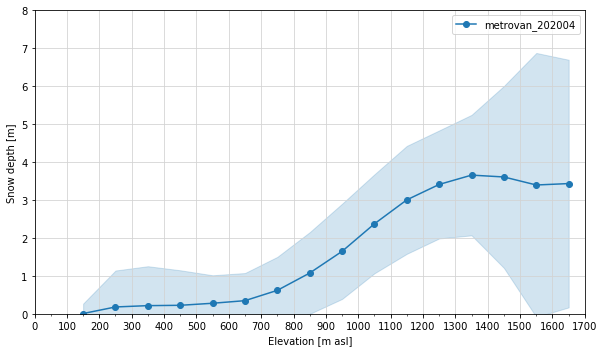

In [15]:
## Code below is a hack. It should be written as a set of functions
## when one has more time (interate over objects and names)

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)




def plot_gradients(dataset, fname_out, color):
    
    plt.rcParams['figure.figsize'] = 8.5, 5
    fig, ax = plt.subplots()

    ax.plot(dataset['Zbins'], dataset['Depth'], '-o', color=color, label=fname_out[0:15])

    ax.fill_between(dataset['Zbins'], dataset['Depth'] - dataset['iqr'], 
                dataset['Depth'] + dataset['iqr'], alpha = 0.2, color=color)    

    ax.set_xlabel('Elevation [m asl]')
    ax.set_ylabel('Snow depth [m]')

    ## These limits are scaled to fit all data 
    ## to keep scaling consistent. These can be cahnged
    ax.set_ylim([0, 8])
    ax.set_xlim([0, 1700])
    
    # Make a plot with major ticks that are multiples of 20 and minor ticks that
    # are multiples of 5.  Label major ticks with '%d' formatting but don't label
    # minor ticks.
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

    # For the minor ticks, use no labels; default NullFormatter.
    ax.xaxis.set_minor_locator(MultipleLocator(50))
    plt.grid(color='lightgrey')

    plt.tight_layout()
    plt.legend()
    
    
    plt.savefig(path + fname_out + '.pdf', dpi=600)

    #return null

    
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']




plot_gradients(metrovan_20200316, 'metrovan_20200316_gradients', colors[5])

plot_gradients(metrovan_20200408, 'metrovan_20200408_gradients', colors[1])

# plot_gradients(lajoie_20180422, 'lajoie_20180422_gradients', colors[2])

# plot_gradients(lajoie_20190318, 'lajoie_20190318_gradients', colors[3])
# plot_gradients(lajoie_20190504, 'lajoie_20190504_gradients', colors[4])

# plot_gradients(lajoie_20200309, 'lajoie_20200309_gradients', colors[5])

# plot_all_gradients(lajoie_20170507, lajoie_20180219, lajoie_20180422, 
#                   lajoie_20190318, lajoie_20190504, lajoie_20200309)


